In [1]:
from sklearn.datasets import make_circles

In [3]:
n_samples = 1000
X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
X[0]

array([0.75424625, 0.23148074])

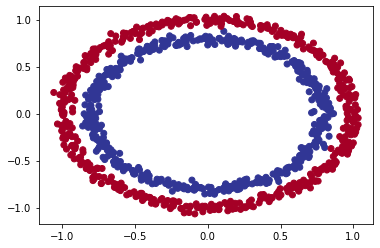

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [8]:
import torch
# lets start with pytorch

In [11]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070 Ti'

In [34]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [17]:
X_train.shape

(800, 2)

In [14]:
from torch import nn

In [27]:
class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [28]:
model_0 = ModelV0().to('cuda')
model_0

ModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [29]:
model_0_seq = nn.Sequential(nn.Linear(in_features=2, out_features=5),
                            nn.Linear(in_features=5, out_features=1)).to('cuda')
model_0_seq

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [30]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)

In [31]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [37]:
device = 'cuda'

In [38]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.4887],
        [-0.4451],
        [-0.3828],
        [-0.5197],
        [-0.0331]], device='cuda:0', grad_fn=<SliceBackward0>)

In [39]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3802],
        [0.3905],
        [0.4054],
        [0.3729],
        [0.4917]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [40]:
y_preds = torch.round(y_pred_probs)
y_pred_labels =  torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [41]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [42]:
y_preds.shape

torch.Size([5, 1])

In [47]:
torch.manual_seed(42)

epochs=100
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits,
                  y_train)
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70732, Accuracy: 41.50% | Test loss: 0.70545, Test acc: 44.00%
Epoch: 10 | Loss: 0.70319, Accuracy: 40.75% | Test loss: 0.70150, Test acc: 43.50%
Epoch: 20 | Loss: 0.69995, Accuracy: 43.75% | Test loss: 0.69846, Test acc: 45.50%
Epoch: 30 | Loss: 0.69757, Accuracy: 45.50% | Test loss: 0.69629, Test acc: 46.00%
Epoch: 40 | Loss: 0.69592, Accuracy: 47.12% | Test loss: 0.69487, Test acc: 47.00%
Epoch: 50 | Loss: 0.69485, Accuracy: 48.25% | Test loss: 0.69401, Test acc: 45.00%
Epoch: 60 | Loss: 0.69418, Accuracy: 48.75% | Test loss: 0.69356, Test acc: 47.00%
Epoch: 70 | Loss: 0.69377, Accuracy: 49.25% | Test loss: 0.69337, Test acc: 46.00%
Epoch: 80 | Loss: 0.69352, Accuracy: 50.50% | Test loss: 0.69334, Test acc: 45.50%
Epoch: 90 | Loss: 0.69335, Accuracy: 50.25% | Test loss: 0.69339, Test acc: 48.00%


In [49]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [50]:
from helper_functions import plot_predictions, plot_decision_boundary

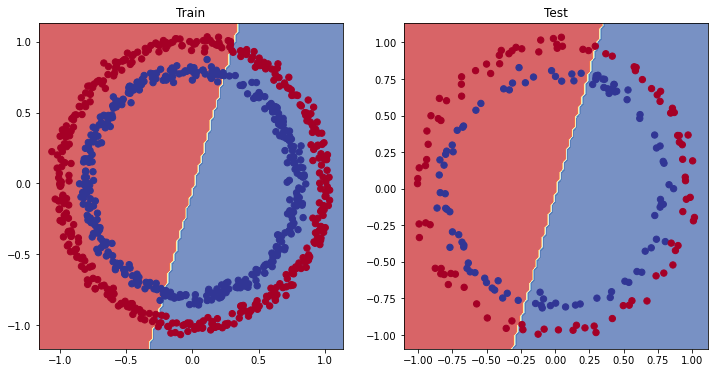

In [51]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [54]:
class Model_V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [55]:
model_1 = Model_V1().to(device)
print(model_1)

Model_V1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [59]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.01)

In [60]:
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_1(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69203, Test Accuracy: 55.50%
Epoch: 100 | Loss: 0.17334, Accuracy: 99.62% | Test Loss: 0.20684, Test Accuracy: 99.00%
Epoch: 200 | Loss: 0.01503, Accuracy: 100.00% | Test Loss: 0.02743, Test Accuracy: 100.00%
Epoch: 300 | Loss: 0.00581, Accuracy: 100.00% | Test Loss: 0.01481, Test Accuracy: 100.00%
Epoch: 400 | Loss: 0.00317, Accuracy: 100.00% | Test Loss: 0.01065, Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.00200, Accuracy: 100.00% | Test Loss: 0.00874, Test Accuracy: 100.00%
Epoch: 600 | Loss: 0.00138, Accuracy: 100.00% | Test Loss: 0.00754, Test Accuracy: 100.00%
Epoch: 700 | Loss: 0.00101, Accuracy: 100.00% | Test Loss: 0.00677, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.00076, Accuracy: 100.00% | Test Loss: 0.00622, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.00060, Accuracy: 100.00% | Test Loss: 0.00579, Test Accuracy: 100.00%


In [61]:
model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

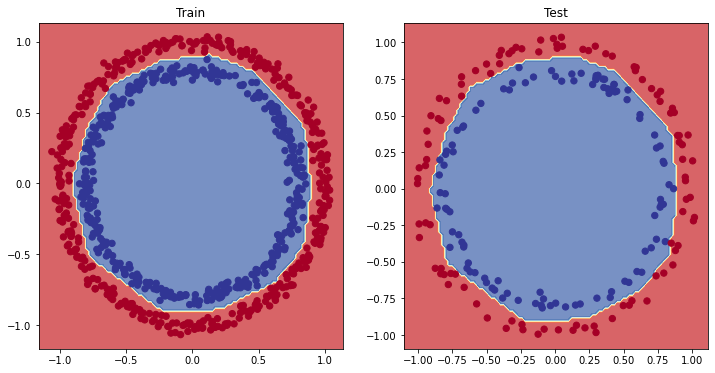

In [62]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test) # model_3 = has non-linearity

In [63]:
model_1

Model_V1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

So lets build Cifar10 model

In [66]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [67]:
train_data = datasets.FashionMNIST(
    root="./datasets/fashionmnnist/train",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="./datasets/fashionmnnist/test",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./datasets/fashionmnnist/train\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./datasets/fashionmnnist/train\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./datasets/fashionmnnist/train\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./datasets/fashionmnnist/train\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./datasets/fashionmnnist/train\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets/fashionmnnist/train\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./datasets/fashionmnnist/train\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets/fashionmnnist/train\FashionMNIST\raw



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./datasets/fashionmnnist/test\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./datasets/fashionmnnist/test\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./datasets/fashionmnnist/test\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./datasets/fashionmnnist/test\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./datasets/fashionmnnist/test\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets/fashionmnnist/test\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./datasets/fashionmnnist/test\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets/fashionmnnist/test\FashionMNIST\raw



In [68]:
classes = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


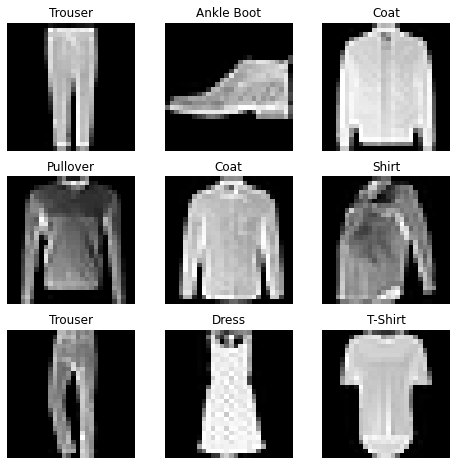

In [79]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    print(img.shape)
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [126]:
from torch.utils.data import DataLoader

In [123]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [124]:
len(train_dataloader)

1875

In [125]:
1875 * 32

60000

In [127]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [128]:
class Model_V2(nn.Module):
    def __init__(self, input_shape, output_shape, neurons=16):
        super().__init__()
        self.layer_stack= nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=neurons),
            nn.ReLU(),
            nn.Linear(in_features=neurons, out_features=output_shape)
        )
    def forward(self, x):
        return self.layer_stack(x)

In [93]:
next(iter(train_dataloader))[0][0].shape

torch.Size([1, 28, 28])

In [129]:
model_2 = Model_V2(input_shape=784,
                  neurons=16,
                  output_shape=len(classes)).to(device)
next(model_2.parameters()).device

device(type='cuda', index=0)

In [130]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                            lr=0.01)

In [131]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [132]:
from tqdm.auto import tqdm

torch.manual_seed(1)

train_time = timer()

epochs=5

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch} \n ------")
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_2.train()
        X, y = X.to(device), y.to(device)
        y_pred = model_2(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)}")
    train_loss /= len(train_dataloader)
    test_loss, test_acc = 0, 0
    model_2.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            X, y = X.to(device), y.to(device)
            test_pred = model_2(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end= timer()
total_train_time_model_2 = print_train_time(start=train_time, 
                                           end=train_time_end,
                                           device=str(next(model_2.parameters()).device))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 
 ------
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000

Train loss: 0.55028 | Test loss: 0.49257, Test acc: 82.14%

Epoch 1 
 ------
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000

Train loss: 0.46553 | Test loss: 0.47097, Test acc: 83.97%

Epoch 2 
 ------
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000

Train loss: 0.45035 | Test loss: 0.45062, Test acc: 83.81%

Epoch 3 
 ------
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000

Train loss: 0.44583 | Test loss: 0.46230, Test acc: 83.76%

Epoch 4 
 ------
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000

Train loss: 0.42739 | Test loss: 0.47644, Test acc: 83.44%

Train time on cuda:0: 49.572 seconds


In [210]:
import numpy as np

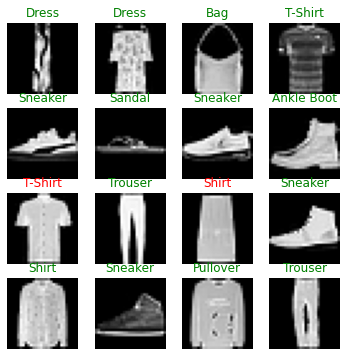

In [223]:
figure = plt.figure(figsize=(6, 6))
j = 32
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    X_test, y_test = test_data[j]
    X_test_device = X_test.to(device)
    y_pred_visual = model_2(X_test_device)
    y_pred = y_pred_visual.argmax(dim=1).cpu().detach().numpy()
    j = j + 1
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    if y_pred_visual.argmax(dim=1) == y_test:
        plt.title(classes[y_test], color="green")
    else:
        plt.title(classes[y_pred[0]], color="red")
    plt.imshow(X_test.squeeze(), cmap="gray")
plt.show()

In [170]:
len(X_test), X_test.shape

(1, torch.Size([1, 28, 28]))

In [153]:
for i range(32):
    X_test

10016